In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.driver.maxResultSize', '18g').getOrCreate()

In [2]:
pip install wordcloud

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 159 kB 111 kB/s            
You should consider upgrading via the '/Users/zhanglixiang/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install nltk

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/Users/zhanglixiang/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords #停用词
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import string
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhanglixiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhanglixiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def remove_upprintable_chars(s):
    
    return ''.join(x for x in s if x.isprintable())
# 分词操作是 word_tokenize() 之后转换成小写
def preprocess(text):
        text = re.sub('[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~\s]+', " ", text)
        text = re.sub('[\001\002\003\004\005\006\007\n\x08\x09\x0a\x0b\x0c\x0d\x0e\x0f\x10\x11\x80\x90\x12\x13\x14\x15\x16\x17\x18\x19\x1a]+', '', text)
        tokens= word_tokenize(text)
        token_list =[remove_upprintable_chars(word.lower()) for word in tokens]
        filtered=[w for w in token_list if(w not in stopwords.words('english'))]
        
        return ' '.join(filtered)

In [6]:
from pyspark.sql.functions import lit,col
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [7]:
def judgeAff(lst):
    aff=lst[0]
    if int(float(aff))<1:
        return 0
    else:
        return 1 

In [9]:
df =spark.read.load('dbfs:/mnt/lsde/group05/wordcloud_comment_sample.parquet',format="parquet")


In [10]:
df.show()

+-------+--------------------+------+
|     id|                body|result|
+-------+--------------------+------+
|hyxxqi1|we'll they have b...| [0.0]|
|hyxxx4i|&gt; Just wow wow...| [0.0]|
|hyxxxbh|Because the left ...| [0.0]|
|hyxxywd|Humanitarian aid ...| [0.0]|
|hyxy3hq|How’d that work o...| [0.0]|
|hyxy40p|1. The convoy to ...| [0.0]|
|hyxy6rl|  #OneBulletSolution| [1.0]|
|hyxyc1a|I can barely fini...| [0.0]|
|hyxyf5l|This is what demo...| [1.0]|
|hyxyhxi|This is fake prop...| [0.0]|
|hyxymng|So what you’re sa...| [1.0]|
|hyxyusk|So much for that ...| [0.0]|
|hyxyutc|&gt;Large explosi...| [0.0]|
|hyxzak0|The "drills" that...| [0.0]|
|hyxzalm|double standards ...| [1.0]|
|hyxzjby|Awww poor little ...| [0.0]|
|hyxzolr|Moron, idiot,brai...| [0.0]|
|hyxzp0e|The blast footage...| [0.0]|
|hyxzvcb|We live in a simu...| [0.0]|
|hyxzwf2|There’s plenty of...| [0.0]|
+-------+--------------------+------+
only showing top 20 rows



In [11]:
judgeAff_f = udf(judgeAff, IntegerType())

In [12]:
spark.udf.register(name="judgeAff_f", f=judgeAff_f)

<function __main__.judgeAff(lst)>

In [13]:
df_withAff = df.withColumn("aff",judgeAff_f('result'))

In [14]:
df_Ukr= df_withAff.filter(col('aff')==0)

In [15]:
df_Russia = df_withAff.filter(col('aff')==1)

In [16]:
df_Ukr_pd=df_Ukr.toPandas()

In [17]:
df_Russia_pd = df_Russia.toPandas()

In [18]:
df_Ukr_pd['text']=df_Ukr_pd['body'].apply(preprocess)

In [19]:
df_Russia_pd['text'] = df_Russia_pd['body'].apply(preprocess)

In [20]:
def getWordList(df,lst):
    for i in range(0,len(df)):
        cur =df.iloc[[i],[4]]['text'].values[0].split(' ')
        lst.extend(cur)
    return lst

In [21]:
russia_lst = getWordList(df_Russia_pd,[])
ukr_lst = getWordList(df_Ukr_pd,[])

In [22]:
from collections import Counter
from wordcloud import WordCloud

In [23]:
count_ukr =Counter(ukr_lst)
count_rus=Counter(russia_lst)

In [24]:
def gen_wordcloud(tup):
    wordcloud =WordCloud(background_color='white',max_words=70,max_font_size=40,random_state=41).generate(str(tup))
    return wordcloud

Text(0.5, 1.0, 'Word cloud of pro-Ukraine comments')

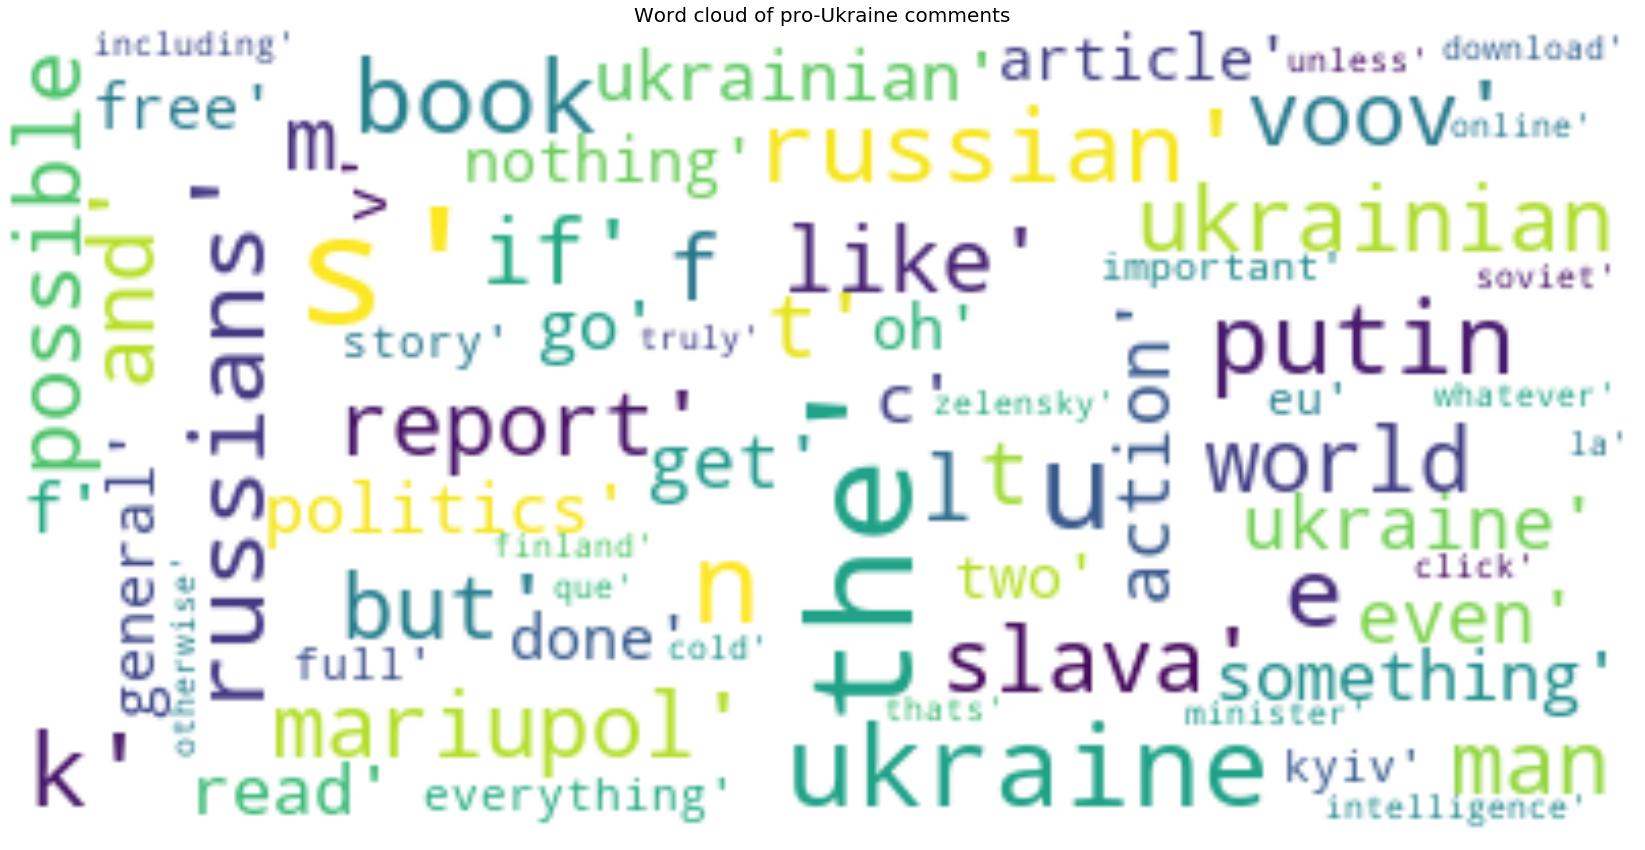

In [25]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(30,15))
ax.imshow(gen_wordcloud(count_ukr),interpolation="bilinear")
ax.axis("off")
ax.set_title("Word cloud of pro-Ukraine comments",fontsize=20)

Text(0.5, 1.0, 'Word cloud of pro-Russia comments')

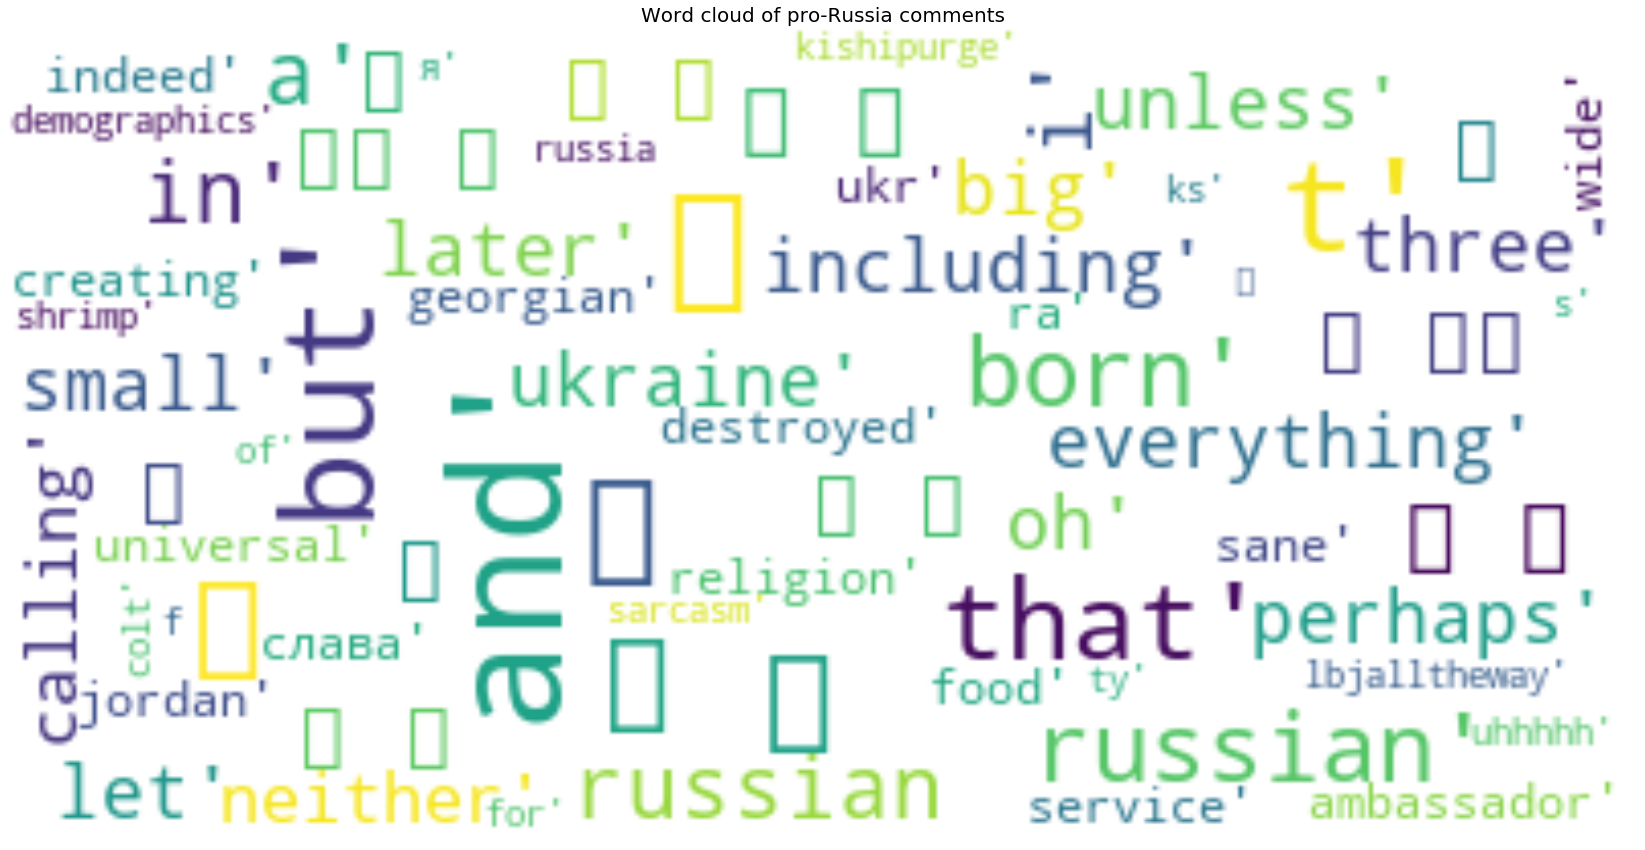

In [26]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(30,15))
ax.imshow(gen_wordcloud(count_rus),interpolation="bilinear")
ax.axis("off")
ax.set_title("Word cloud of pro-Russia comments",fontsize=20)